In [68]:
#%reset

import tweepy
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from wordcloud import WordCloud
from nltk.util import ngrams

from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Embedding, LSTM
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [108]:
# Add your Bearer token here.
client = tweepy.Client(bearer_token='')

# Create Pandas dataframe with three columns
tweet_df = pd.DataFrame(columns=['text', 'language'])

# Query tweets with #news. Show only 100 tweets
query = '#news'
tweets = client.search_recent_tweets(query=query, tweet_fields=['lang'], max_results=100)

for tweet in tweets.data:
    text = tweet.text
    language = tweet.lang

    # Focus only to tweets in english
    if language == 'en':
        tmp = [text, language]
        tweet_df.loc[len(tweet_df)] = tmp

# Total amount of tweets in dataframe
print('Amount: ', len(tweet_df))

# Show first 5 lines of dataframe
tweet_df.head()

Amount:  75


,text,language
0,A Ukrainian woman who heard explosions near he...,en
1,RT @bulldomains: .\nDomain Name For Sale\n\nht...,en
2,RT @bulldomains: .\nDomain Name For Sale\n\nht...,en
3,RT @bulldomains: .\nDomain Name For Sale\n\nht...,en
4,Maximum temperature likely to settle at nearly...,en


In [9]:
# Read .csv files from local disk
truenews = pd.read_csv("../files/True.csv")
fakenews = pd.read_csv("../files/Fake.csv")

# Create new column, which indicates the truthness of the news
truenews['label'] = 1
fakenews['label'] = 0

# Concatenate the two dataframes into one
news_df = pd.concat([truenews, fakenews], ignore_index=True, sort=False)

news_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [12]:
# Add title and subject to text field
news_df['text'] = news_df['subject'] + " " + news_df['title'] + " " + news_df['text']

news_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...","politicsNews As U.S. budget fight looms, Repub...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,politicsNews U.S. military to accept transgend...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews Senior U.S. Republican senator: '...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,politicsNews FBI Russia probe helped by Austra...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,politicsNews Trump wants Postal Service to cha...,politicsNews,"December 29, 2017",1


In [13]:
# Remove unnecessary columns
del news_df['title']
del news_df['subject']
del news_df['date']

news_df.head()

,text,label
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [109]:
print("Does Twitter Dataframe contain null values:", tweet_df.isnull().values.any())
print("Does News Dataframe contain null values:", news_df.isnull().values.any(), "\n")

print("Twitter dataframe datatypes:\n", tweet_df.dtypes, "\n")
print("News dataframe datatypes:\n", news_df.dtypes)

Does Twitter Dataframe contain null values: False
Does News Dataframe contain null values: False 

Twitter dataframe datatypes:
 text        object
language    object
dtype: object 

News dataframe datatypes:
 text          object
label          int64
clean_text    object
dtype: object


In [46]:
def emoticons_remove(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

# Remove all HTML contents
def html_remove(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove punctuations
def punctuations_remove(text):
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    return text

# Remove links
def links_remove(text):
    return re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)

# Remove hashtags
def hashtags_remove(text):
    return re.sub("#[A-Za-z0-9_]+","", text)

# Remove mentions
def mentions_remove(text):
    return re.sub("@[A-Za-z0-9]+","", text)

# Remove special characters
def characters_remove(text):
    return re.sub("[^a-zA-Z]"," ", text)

# Remove stopwords and lemmatize words that are not recognized
def stopwords_remove_and_lemmatization(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join([word for word in tokens if not word in stop_words])

def clean_text(text):
    text = html_remove(text)
    text = punctuations_remove(text)
    text = links_remove(text)
    text = hashtags_remove(text)
    text = mentions_remove(text)
    text = emoticons_remove(text)
    text = characters_remove(text)
    text = stopwords_remove_and_lemmatization(text)

    return text

test_text = "The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live"
print("Before: ", test_text)
print("After: ", clean_text(test_text), "\n")
test_text2 = "I want to Remove all white \t spaces, new lines \n and tabs \t"
print("Before:", test_text2)
print("After:", clean_text(test_text2))


Before:  The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live
After:  dragon endeavour four astronaut holding meter away station station crew work video routing issue 

Before: I want to Remove all white 	 spaces, new lines 
 and tabs 	
After: want remove white space new line tab


In [44]:
news_df['clean_text'] = news_df['text'].apply(clean_text)

news_df.head()

,text,label,clean_text
0,"politicsNews As U.S. budget fight looms, Repub...",1,politicsnews u budget fight loom republican fl...
1,politicsNews U.S. military to accept transgend...,1,politicsnews u military accept transgender rec...
2,politicsNews Senior U.S. Republican senator: '...,1,politicsnews senior u republican senator let m...
3,politicsNews FBI Russia probe helped by Austra...,1,politicsnews fbi russia probe helped australia...
4,politicsNews Trump wants Postal Service to cha...,1,politicsnews trump want postal service charge ...


In [110]:
tweet_df['clean_text'] = np.nan

tweet_df['clean_text'] = [clean_text(x) for x in tweet_df['text']]

del tweet_df['language']

tweet_df.head()

C:\ProgramData\Anaconda3\envs\JODA\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,text,clean_text
0,A Ukrainian woman who heard explosions near he...,ukrainian woman heard explosion near apartment...
1,RT @bulldomains: .\nDomain Name For Sale\n\nht...,rt domain name sale
2,RT @bulldomains: .\nDomain Name For Sale\n\nht...,rt domain name sale
3,RT @bulldomains: .\nDomain Name For Sale\n\nht...,rt domain name sale
4,Maximum temperature likely to settle at nearly...,maximum temperature likely settle nearly degre...


In [51]:
X_train, X_test, y_train, y_test = train_test_split(news_df['clean_text'], news_df['label'], random_state=0)

In [52]:
maxlen = 300
max_features = 10000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

def tokenize(text):
    tokenized = tokenizer.texts_to_sequences(text)
    return sequence.pad_sequences(tokenized, maxlen=maxlen)

X_train = tokenize(X_train)
X_test = tokenize(X_test)

In [64]:
print("Sequence:", list(X_train[1]))
print("Label:",y_train[1])

Sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 6, 184, 101, 14, 1464, 571, 274, 1417, 767, 4068, 5221, 477, 41, 6, 184, 101, 14, 1464, 571, 274, 1417, 767, 4068, 5221, 477, 41, 6, 184, 101, 14, 1464, 571, 274, 1417, 767, 4068, 5221, 477, 55, 178, 875, 1417, 477, 387, 1432, 1126, 318, 2066, 973, 418, 74, 508, 249, 1086, 10, 250, 409, 3772, 2861, 1971, 5070, 1464, 504, 5070, 56, 117, 39, 1417, 3134, 54, 483, 5901, 5360, 920, 5705, 118, 301, 2494, 599, 750, 862, 2500, 1417, 477, 387, 81, 2156, 1088, 218, 920, 10, 250, 2293, 2873, 488, 1682, 5070, 1464, 287, 87, 5261, 240, 374, 486, 1417, 209, 1369, 850, 144, 3, 1680, 274, 106, 420, 854, 374, 7120, 477, 1773, 305, 184, 403, 157, 101, 4813, 9503, 1086, 182, 1055, 1464, 4324, 477, 7, 390, 554, 770, 475, 571, 112, 1086, 110, 1369, 2969, 39, 184, 9503, 2, 3, 359, 1417, 810, 248, 1889, 477, 1043, 374, 6543, 4324, 

In [65]:
tokenized_counts = Counter(tokenizer.word_counts)
tokenized_df = pd.DataFrame([tokenized_counts.keys(), tokenized_counts.values()]).T
tokenized_df.columns=['word', 'quantity']
tokenized_df = tokenized_df.sort_values(by='quantity', ascending=False)

tokenized_df.head(10)

,word,quantity
409,trump,134494
21,said,99996
113,wa,89358
1,u,69013
23,ha,68854
40,news,53474
15,state,49308
336,president,46434
174,would,42804
67,republican,33808


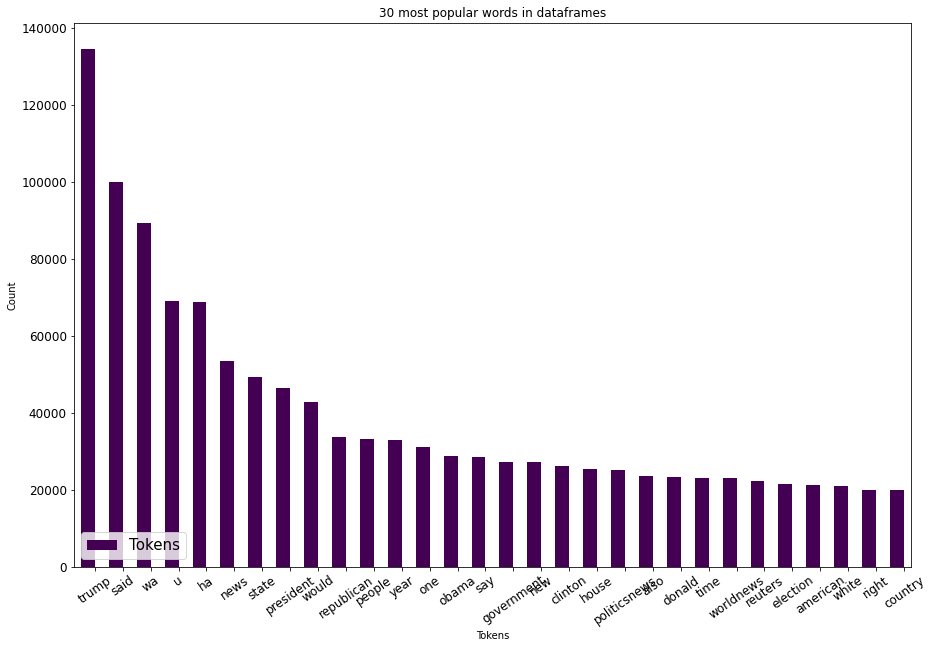

In [66]:
tokenized_df[:30].plot(kind="bar",x="word", orientation="vertical", figsize=(15,10), xlabel="Tokens", ylabel="Count", colormap="viridis", table=False, grid=False, fontsize=12, rot=35, position=1, title="30 most popular words in dataframes", legend=True).legend(["Tokens"], loc="lower left", prop={"size":15})

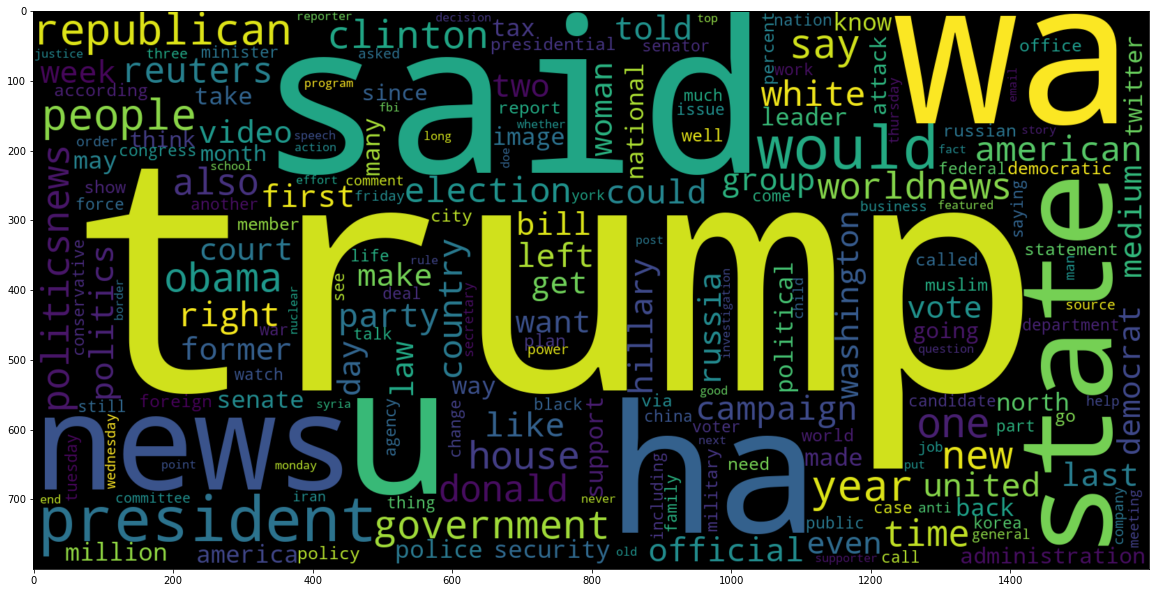

In [67]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 200, width = 1600, height= 800).generate_from_frequencies(tokenized_counts)
plt.imshow(wc, interpolation = 'bilinear')

<AxesSubplot:title={'center':'Longest 200 tweet/news lengths'}, xlabel='index', ylabel='word count'>

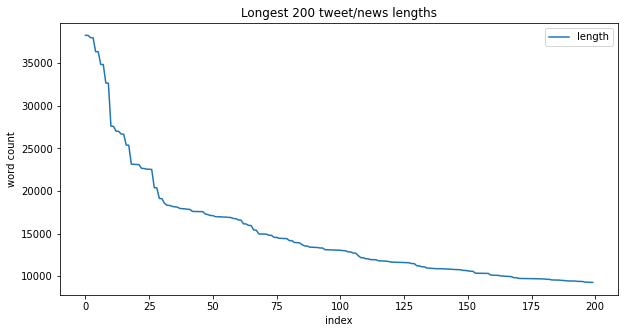

In [111]:
ctc = pd.concat([news_df['clean_text'], tweet_df['clean_text']])
length_df = pd.DataFrame(columns=['length'])
length_df['length'] = [len(i) for i in ctc]
length_df.sort_values(by=['length'], inplace=True, ascending=False)
length_df = length_df.reset_index(drop=True)
length_df[:200].plot(title="Longest 200 tweet/news lengths", figsize=(10,5), xlabel='index', ylabel='word count')

<AxesSubplot:>

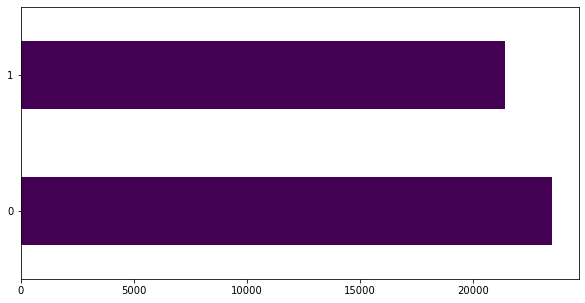

In [69]:
news_df['label'].value_counts().plot(kind='barh', figsize=(10,5), colormap="viridis")

In [112]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([x for x in ctc])
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
said,1.313007
wa,1.336014
ha,1.381333
president,1.634007
would,1.674555
...,...
resourceful,11.020693
resourcesbrezler,11.020693
resparking,11.020693
cntinued,11.020693


<AxesSubplot:>

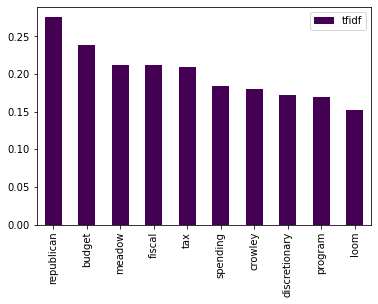

In [113]:
count_vector = cv.transform([x for x in ctc])
tf_idf_vector = tfidf_transformer.transform(count_vector)

feature_names = cv.get_feature_names_out()
first_document_vector=tf_idf_vector[0] 
tf_idf_df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
tf_idf_df = tf_idf_df.sort_values(by=["tfidf"],ascending=False)
tf_idf_df[:10].plot(kind="bar", colormap="viridis")

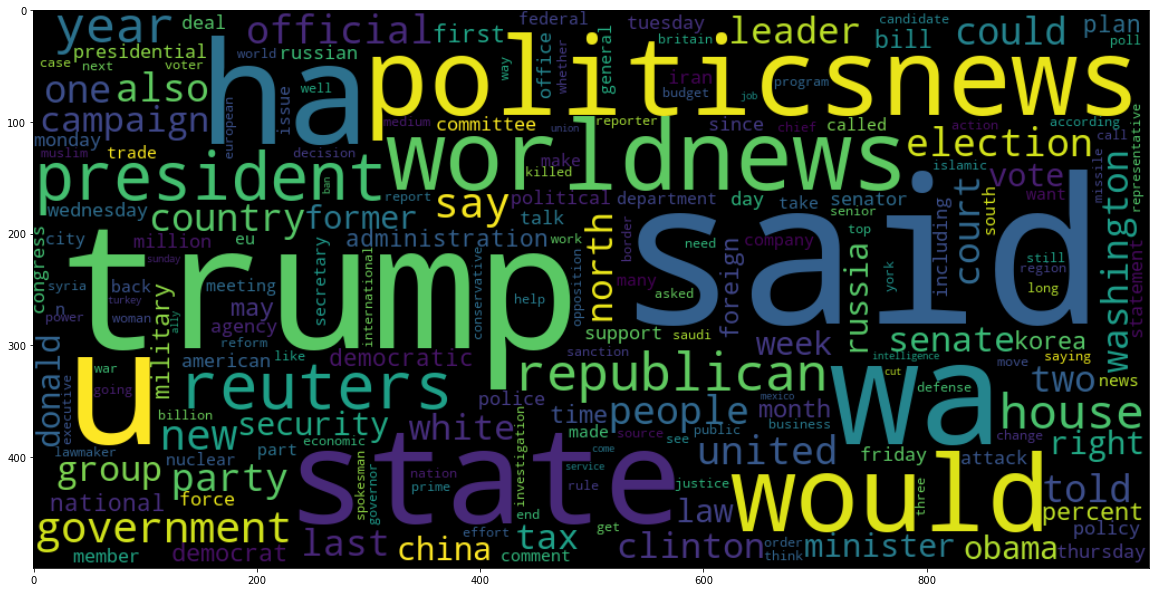

In [85]:
plt.figure(figsize=(20,20))
true_df = news_df[news_df['label'] == 1]
tokenizer_true = Tokenizer()
tokenizer_true.fit_on_texts([x for x in true_df['clean_text']])
tokenized_counts_true = Counter(tokenizer_true.word_counts)
wc_true = WordCloud(max_words= 200, width = 1000, height= 500).generate_from_frequencies(tokenized_counts_true)
plt.imshow(wc_true, interpolation = 'bilinear')

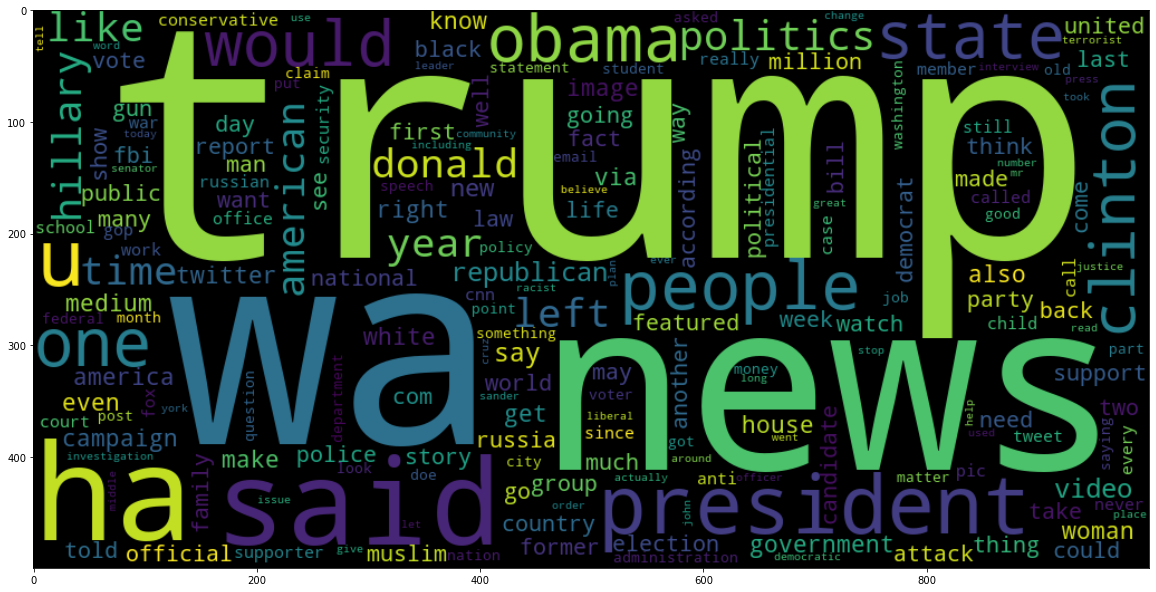

In [86]:
plt.figure(figsize=(20,20))
false_df = news_df[news_df['label'] == 0]
tokenizer_false = Tokenizer()
tokenizer_false.fit_on_texts([x for x in false_df['clean_text']])
tokenized_counts_false = Counter(tokenizer_false.word_counts)
wc_false = WordCloud(max_words= 200, width = 1000, height= 500).generate_from_frequencies(tokenized_counts_false)
plt.imshow(wc_false, interpolation = 'bilinear')

<AxesSubplot:title={'center':'20 Most frequently Occuring Bigrams (True Dataset)'}, ylabel='Bigram'>

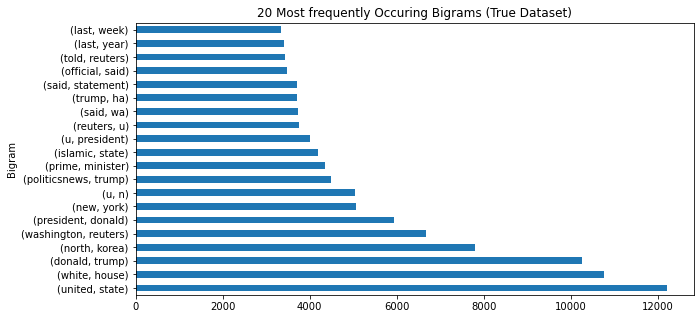

In [87]:
true_word = ''.join(true_df['clean_text'].tolist())
true_bigrams_series = pd.Series(ngrams(true_word.split(), 2))
true_bigrams_series = true_bigrams_series.value_counts()
true_bigrams_series = true_bigrams_series.sort_values(ascending=False)
true_bigrams_series[:20].plot(kind='barh', figsize=(10,5), xlabel='Bigram', ylabel='# of Occurances', title='20 Most frequently Occuring Bigrams (True Dataset)')

<AxesSubplot:title={'center':'20 Most frequently Occuring Bigrams (False Dataset)'}, ylabel='Bigram'>

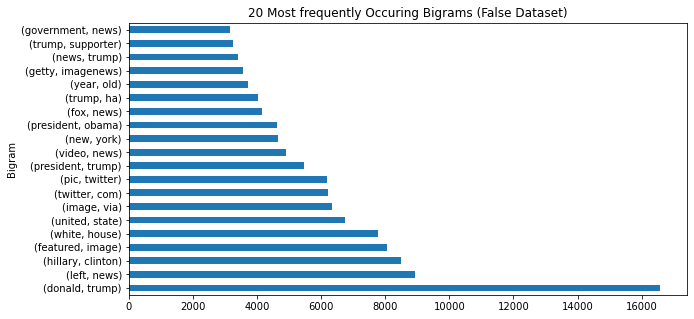

In [88]:
false_word = ''.join(false_df['clean_text'].tolist())
false_bigrams_series = pd.Series(ngrams(false_word.split(), 2))
false_bigrams_series = false_bigrams_series.value_counts()
false_bigrams_series = false_bigrams_series.sort_values(ascending=False)
false_bigrams_series[:20].plot(kind='barh', figsize=(10,5), xlabel='Bigram', ylabel='# of Occurances', title='20 Most frequently Occuring Bigrams (False Dataset)')

In [54]:
batch_size = 256
epochs = 10
embed_size = 100

In [55]:
model = Sequential()

model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [56]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 [==============================] - 171s 2s/step - loss: 0.4845 - accuracy: 0.7484 - val_loss: 0.4373 - val_accuracy: 0.7906
Epoch 2/10
93/93 [==============================] - 174s 2s/step - loss: 0.3591 - accuracy: 0.8421 - val_loss: 0.3316 - val_accuracy: 0.8455
Epoch 3/10
93/93 [==============================] - 169s 2s/step - loss: 0.2545 - accuracy: 0.8996 - val_loss: 0.2175 - val_accuracy: 0.9205
Epoch 4/10
93/93 [==============================] - 170s 2s/step - loss: 0.2781 - accuracy: 0.8905 - val_loss: 0.2357 - val_accuracy: 0.9103
Epoch 5/10
93/93 [==============================] - 172s 2s/step - loss: 0.2295 - accuracy: 0.9101 - val_loss: 0.2167 - val_accuracy: 0.9140
Epoch 6/10
93/93 [==============================] - 175s 2s/step - loss: 0.2496 - accuracy: 0.9025 - val_loss: 0.2181 - val_accuracy: 0.9158
Epoch 7/10
93/93 [==============================] - 176s 2s/step - loss: 0.1754 - accuracy: 0.9352 - val_loss: 0.1016 - val_accuracy: 0.9629
Epoch 8/10
93

In [96]:
print("Test the accuracy of the model with Testing data:", model.evaluate(X_test, y_test))

351/351 [==============================] - 31s 89ms/step - loss: 0.0407 - accuracy: 0.9850
Test the accuracy of the model with Testing data: [0.04065953940153122, 0.985033392906189]


In [97]:
predict = model.predict_classes(X_test)
print(classification_report(y_test, predict))

C:\ProgramData\Anaconda3\envs\JODA\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5858
           1       0.97      1.00      0.98      5367

    accuracy                           0.99     11225
   macro avg       0.98      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [98]:
model.save('classifier.h5')

In [138]:
tweet_sequence = tokenize(tweet_df['clean_text'])

predict_tweet = model.predict_classes(tweet_sequence)
predict_tweet = ['true' if prediction == 1 else 'false' for prediction in predict_tweet]

tweet_prediction_df = tweet_df.copy()
tweet_prediction_df['label'] = predict_tweet

tweet_prediction_df.drop_duplicates(subset='clean_text', keep=False, inplace=True)

tweet_prediction_df.head(10)

C:\ProgramData\Anaconda3\envs\JODA\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,text,clean_text,label
0,A Ukrainian woman who heard explosions near her apartment stepped outside to find her father's dead body on the sidewalk https://t.co/2vqPQP5JPs Earn money now. Work on the Internet! https://t.co/XBKDNZ447g (#Siguemeytesigo) (#Followback) (#News) (#SDV),ukrainian woman heard explosion near apartment stepped outside find father dead body sidewalk earn money work internet,true
4,Maximum temperature likely to settle at nearly 40 degrees C in Delhi: IMD https://t.co/f84SO3iom7 #Business #News,maximum temperature likely settle nearly degree c delhi imd,true
5,Zurich turns off gas to fight climate change and Russia : NPR \n\n#russia #news\n\nhttps://t.co/ESxAhEz1UG,zurich turn gas fight climate change russia npr,true
6,"RT @A_Crypto_Kay: @CryptoMichNL 100X 1000X🚨! EXCHANGE EXCHANGES ON THE WAY! CMC HAS NOT ARRIVED YET! METAVERSE,NFT LERS ARE ON THE WAY :)…",rt x x exchange exchange way cmc ha arrived yet metaverse nft ler way,true
8,"RT @TLund32926493: Here's a great example of the real Biden and the Fake Biden with a cleft in his chin, tucked ears, forhead lines don't m…",rt great example real biden fake biden cleft chin tucked ear forhead line,true
9,RT @Sasithorns: Thai Food - Pork Omlette\nhttps://t.co/XEboHULBhY\n#bynong #Thailand #Thaifood #food #Cooking #news #Nigeria #Ukraine️ #Russi…,rt thai food pork omlette,true
10,The latest The Digital games in school Daily! https://t.co/AM9zEISoqj Thanks to @sanesh_TNIE #esports #news,latest digital game school daily thanks,true
11,RT @etribune: The Pakistan Tehreek-e-Insaf (PTI) grand power show is underway at the historic Minar-e-Pakistan in Lahore against the agains…,rt pakistan tehreek e insaf pti grand power show underway historic minar e pakistan lahore agains,true
14,.\nDomain Name For Sale\n\nhttps://t.co/t28THE7fCC\n\n#CashWinners #Lottery #litto #Cash #Winners #Winner #Win #Winning #Domain #Marketing #Media #News #entrepreneur #socialmedia #100DaysOfCode #javascript #python #Apple #vr #Microsoft #Linux #bot #Business #Startups #Startup #brand https://t.co/OT0VAyCxc2,domain name sale,true
15,"RT @ANOVNI1: Greetings #Srilankan #SriLanka #news \n#Rajapaksas Obtained data by #hacking of #financial reports, #offshore #bank accounts,pr…",rt greeting obtained data report account pr,true


<AxesSubplot:>

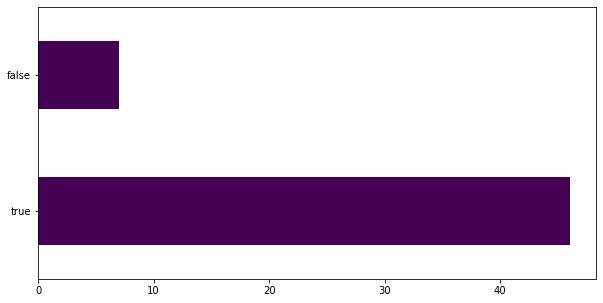

In [139]:
tweet_prediction_df['label'].value_counts().plot(kind='barh', figsize=(10,5), colormap="viridis")

In [145]:
pd.set_option('display.max_colwidth', None)
tp_false_df = tweet_prediction_df[tweet_prediction_df['label'] == 'false']
tp_false_df.head(5)

,text,clean_text,label
16,Three-day Global AYUSH Investment and Innovation Summit held in Gandhinagar https://t.co/yZXvt3Arsb #news,three day global ayush investment innovation summit held gandhinagar,false
23,The news at 17:55:01 is News Source: Birmingham Live Title: Murder arrest over body found in Good Hope Hospital car park - Birmingham Live https://t.co/GtlcQDUu00 #news #headlines,news news source birmingham live title murder arrest body found good hope hospital car park birmingham live,false
24,RT @WilliamMPlante2: Keto Diet: Everything You Should Know Before You Start\nGetty Images\nThe ketogenic diet is an eating plan that's been u…,rt keto diet everything know start getty image ketogenic diet eating plan u,false
36,10-year-old Algonquin girl shares the traditional skills she's learned on social media - CBC News has been published on Canada News Media - https://t.co/9kgAcUtXcD #news,year old algonquin girl share traditional skill learned social medium cbc news ha published canada news medium,false
37,"Fantastic News for this vibrant city, Newcastle.\n— Local Government Surplus\n\n""Our track record of strong financial management meant that during the pandemic we were able to dip into our savings to stimulate the local economy”\n\n#Newcastle #Australian #news https://t.co/4U3ahyTqx9",fantastic news vibrant city newcastle local government surplus track record strong financial management meant pandemic able dip saving stimulate local economy,false


In [147]:
tp_true_df = tweet_prediction_df[tweet_prediction_df['label'] == 'true']
tp_true_df.head(5)

,text,clean_text,label
0,A Ukrainian woman who heard explosions near her apartment stepped outside to find her father's dead body on the sidewalk https://t.co/2vqPQP5JPs Earn money now. Work on the Internet! https://t.co/XBKDNZ447g (#Siguemeytesigo) (#Followback) (#News) (#SDV),ukrainian woman heard explosion near apartment stepped outside find father dead body sidewalk earn money work internet,true
4,Maximum temperature likely to settle at nearly 40 degrees C in Delhi: IMD https://t.co/f84SO3iom7 #Business #News,maximum temperature likely settle nearly degree c delhi imd,true
5,Zurich turns off gas to fight climate change and Russia : NPR \n\n#russia #news\n\nhttps://t.co/ESxAhEz1UG,zurich turn gas fight climate change russia npr,true
6,"RT @A_Crypto_Kay: @CryptoMichNL 100X 1000X🚨! EXCHANGE EXCHANGES ON THE WAY! CMC HAS NOT ARRIVED YET! METAVERSE,NFT LERS ARE ON THE WAY :)…",rt x x exchange exchange way cmc ha arrived yet metaverse nft ler way,true
8,"RT @TLund32926493: Here's a great example of the real Biden and the Fake Biden with a cleft in his chin, tucked ears, forhead lines don't m…",rt great example real biden fake biden cleft chin tucked ear forhead line,true


In [163]:
extra_df = pd.read_csv("../files/fake_or_real_news.csv")
extra_df['text'] = extra_df['title'] + " " + extra_df['text']

del extra_df['title']
del extra_df['Unnamed: 0']

extra_df['clean_text'] = [clean_text(x) for x in extra_df['text']]

C:\ProgramData\Anaconda3\envs\JODA\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [164]:
pd.set_option('display.max_colwidth', 100)
extra_df.head(2)

,text,label,clean_text
0,"You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Cent...",FAKE,smell hillary fear daniel greenfield shillman journalism fellow freedom center new york writer f...
1,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO) Google Pin...,FAKE,watch exact moment paul ryan committed political suicide trump rally video google pinterest digg...


In [165]:
extra_sequence = tokenize(extra_df['clean_text'])

predict_extra = model.predict_classes(extra_sequence)
predict_extra = ['true' if prediction == 1 else 'false' for prediction in predict_extra]

extra_df['prediction'] = predict_extra

extra_df.head(10)

C:\ProgramData\Anaconda3\envs\JODA\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,text,label,clean_text,prediction
0,"You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Cent...",FAKE,smell hillary fear daniel greenfield shillman journalism fellow freedom center new york writer f...,true
1,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO) Google Pin...,FAKE,watch exact moment paul ryan committed political suicide trump rally video google pinterest digg...,false
2,Kerry to go to Paris in gesture of sympathy U.S. Secretary of State John F. Kerry said Monday th...,REAL,kerry go paris gesture sympathy u secretary state john f kerry said monday stop paris later week...,true
3,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!' — Kaydee Ki...,FAKE,bernie supporter twitter erupt anger dnc tried warn kaydee king november lesson tonight dem loss...,true
4,The Battle of New York: Why This Primary Matters It's primary day in New York and front-runners ...,REAL,battle new york primary matter primary day new york front runner hillary clinton donald trump le...,true
5,"Tehran, USA \nI’m not an immigrant, but my grandparents are. More than 50 years ago, they arri...",FAKE,tehran usa immigrant grandparent year ago arrived new york city iran grew mainly central new jer...,false
6,Girl Horrified At What She Watches Boyfriend Do After He Left FaceTime On Share This Baylee Luci...,FAKE,girl horrified watch boyfriend left facetime share baylee luciani left screenshot baylee caught ...,false
7,‘Britain’s Schindler’ Dies at 106 A Czech stockbroker who saved more than 650 Jewish children fr...,REAL,britain schindler dy czech stockbroker saved jewish child nazi germany ha died age dubbed britai...,true
8,Fact check: Trump and Clinton at the 'commander-in-chief' forum Hillary Clinton and Donald Trump...,REAL,fact check trump clinton commander chief forum hillary clinton donald trump made inaccurate clai...,true
9,Iran reportedly makes new push for uranium concessions in nuclear talks Iranian negotiators repo...,REAL,iran reportedly make new push uranium concession nuclear talk iranian negotiator reportedly made...,true


In [168]:
classification_right = 0
classification_wrong = 0
for index, row in extra_df.iterrows():
    if row['label'] == 'REAL' and row['prediction'] == 'true':
        classification_right += 1
    else:
        classification_wrong += 1

print("Model predicted correctly:", classification_right)
print("Model predicted wrongly:", classification_wrong)

Model predicted correctly: 2679
Model predicted wrongly: 3656
